In [ ]:
"""@Inbook{Matsuyama2021,
author="Matsuyama, Hitoshi
and Hiroi, Kei
and Kaji, Katsuhiko
and Yonezawa, Takuro
and Kawaguchi, Nobuo",
editor="Ahad, Md Atiqur Rahman
and Inoue, Sozo
and Roggen, Daniel
and Fujinami, Kaori",
title="A Basic Study on Ballroom Dance Figure Classification with LSTM Using Multi-modal Sensor",
bookTitle="Activity and Behavior Computing",
year="2021",
publisher="Springer Singapore",
address="Singapore",
pages="209--226",
abstract="The paper presents a ballroom dance figure classification method with LSTM using video and wearable sensors. Ballroom dance is a popular sport among people regardless of age or sex. However, learning ballroom dance is very difficult for less experienced dancers as it has many complex types of ``dance figures'', which is a completed set of footsteps. Therefore, we aim to develop a system to assist dance exercise which gives advice proper to each dance figure characteristic by recognizing dance figures correctly. While the major approach to recognize dance performance is to utilize video, we cannot simply adopt it for ballroom dance because the images of dancers overlap each other. To solve the problem, we propose a hybrid figure recognition method combining video and wearable sensors to enhance its accuracy and robustness. We collect video and wearable sensor data of seven dancers including acceleration, angular velocity, and body parts location change by pose estimation. After that, we preprocess them and put them into an LSTM-based deep learning network. As a result, we confirmed that our approach achieved an F1-score of 0.86 for 13 figure types recognition using the multi-modal sensors with trial-based fivefold cross-validation. We also performed user-based cross-validation, and sliding window algorithms. In addition, we compared the results with our previous method using Random Forest and also evaluated the robustness with occlusions. We found the LSTM-based method worked better than Random Forest with keypoint data. On the other hand, LSTM could not perform well with a sliding window algorithm. We consider the LSTM-based method would work better with a larger dance figure data, which is our next work. In addition, we will investigate how to solve occlusion problems with pose estimation.",
isbn="978-981-15-8944-7",
doi="10.1007/978-981-15-8944-7_13",
url="https://doi.org/10.1007/978-981-15-8944-7_13"
}"""

In [ ]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [ ]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import time
from moviepy.editor import *
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
path =  "/content/drive/MyDrive/Dissertation/Data/"

In [ ]:
labels_df = pd.read_csv(path+'video_labels/dancer1/video_1.csv', header = None, index_col=0)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels_df[1].unique())

LabelEncoder()

In [ ]:
le.inverse_transform(np.array([10]))

array(['NotPerforming'], dtype=object)

In [ ]:
# to save encoder
import joblib
joblib.dump(le,'classes.joblib',compress=9)

['classes.joblib']

In [ ]:
CLASSES_LIST = le.classes_

(-0.5, 1919.5, 1079.5, -0.5)

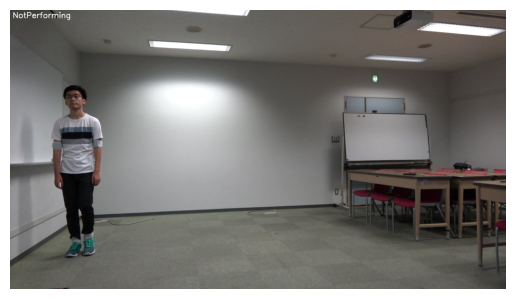

In [ ]:
# Initialize a VideoCapture object to read from the video File.
video_reader = cv2.VideoCapture(path+'videos/dancer1/12.MP4')
labels_df = pd.read_csv(path+'video_labels/dancer1/video_12.csv', header = None, index_col=0)
# labels.columns = ['index', 'label']
# Read the first frame of the video file.
_, bgr_frame = video_reader.read()

# Release the VideoCapture object.
video_reader.release()

# Convert the frame from BGR into RGB format.
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
selected_class_Name = labels_df.iloc[1].values[0]
# Write the class name on the video frame.
cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# Display the frame.
# plt.subplot(5, 4, 1);
plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 14

In [ ]:
# Declare a list to store video frames.
features = []
labels = []
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 14

for dancer in range(1,8):
  for vd in range(2,21):
    labels_list = []
    print('Dancer:', dancer,"\nVideo:",vd)
    try:
      # Read the Video File using the VideoCapture object.
      video_reader = cv2.VideoCapture(path+'videos/dancer{}/{}.MP4'.format(dancer,vd))
      labels_df = pd.read_csv(path+'video_labels/dancer'+str(dancer)+'/video_'+str(vd)+'.csv', header = None, index_col=0)
    except:
      drive.flush_and_unmount()
      drive.mount('/content/drive', force_remount=True)
      # Read the Video File using the VideoCapture object.
      video_reader = cv2.VideoCapture(path+'videos/dancer{}/{}.MP4'.format(dancer,vd))
      labels_df = pd.read_csv(path+'video_labels/dancer'+str(dancer)+'/video_'+str(vd)+'.csv', header = None, index_col=0)
    labels_df.reset_index(drop=True, inplace = True)
    labels_df.columns = ['label']
    for l in labels_df['label'].unique():
      frames_list = []
      idx = labels_df[labels_df['label']== l].index
      # Get the total number of frames in the video.
      # video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
      video_frames_count = len(idx)
      # print(idx)
      # Calculate the the interval after which frames will be added to the list.
      skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
      # Iterate through the Video Frames.
      for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video.
        fr = frame_counter * skip_frames_window
        # print(idx[fr])
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx[fr])

        # le.transform(labels_df.iloc[frame_counter * skip_frames_window])[0] == 0
        # labels_list.append(le.transform(labels_df.iloc[frame_counter * skip_frames_window])[0])
        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

      # break
      print(l, end=',')

      #   print(frame_counter, end = ', ')
      # print()


      # print(frame_counter, end = ',')
    # Release the VideoCapture object.
    # lbl = [skip_frames_start: video_frames_count-skip_frames_end]
    # labels_list.append(le.transform(lbl))
      features.append(frames_list)
      labels.append(le.transform([l])[0])
    video_reader.release()
    print("Done")
features = np.asarray(features)
labels = np.array(labels)

Dancer: 1 
Video: 2
NotPerforming,OpenBasic,FootChange,Fan,HockyStick,NewYorkR,NewYorkL,SpotTurn,NaturalTop,OpeningOut,Alemana,HandToHandR,HandToHandL,Aida,Done
Dancer: 1 
Video: 3
NotPerforming,OpenBasic,FootChange,Fan,HockyStick,NewYorkR,NewYorkL,SpotTurn,NaturalTop,OpeningOut,Alemana,HandToHandR,HandToHandL,Aida,Done
Dancer: 1 
Video: 4
NotPerforming,OpenBasic,FootChange,Fan,HockyStick,NewYorkR,NewYorkL,SpotTurn,NaturalTop,OpeningOut,Alemana,HandToHandR,HandToHandL,Aida,Done
Dancer: 1 
Video: 5
NotPerforming,OpenBasic,FootChange,Fan,HockyStick,NewYorkR,NewYorkL,SpotTurn,NaturalTop,OpeningOut,Alemana,HandToHandR,HandToHandL,Aida,Done
Dancer: 1 
Video: 6
NotPerforming,OpenBasic,FootChange,Fan,HockyStick,NewYorkR,NewYorkL,SpotTurn,NaturalTop,OpeningOut,Alemana,HandToHandR,HandToHandL,Aida,Done
Dancer: 1 
Video: 7
NotPerforming,OpenBasic,FootChange,Fan,HockyStick,NewYorkR,NewYorkL,SpotTurn,NaturalTop,OpeningOut,Alemana,HandToHandR,HandToHandL,Aida,Done
Dancer: 1 
Video: 8
NotPerforming,

In [ ]:
features.shape

(1862, 14, 64, 64, 3)

In [ ]:
# features = np.asarray(features)
# labels = np.array(labels)
features.tofile(path+'features.txt')
labels.tofile(path+'labels.txt')

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
one_hot_encoded_labels.shape

(1862, 14)

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 14, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 14, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 14, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 14, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 14, 15, 15, 8)     0         
 g3D)                                                            
                                                        

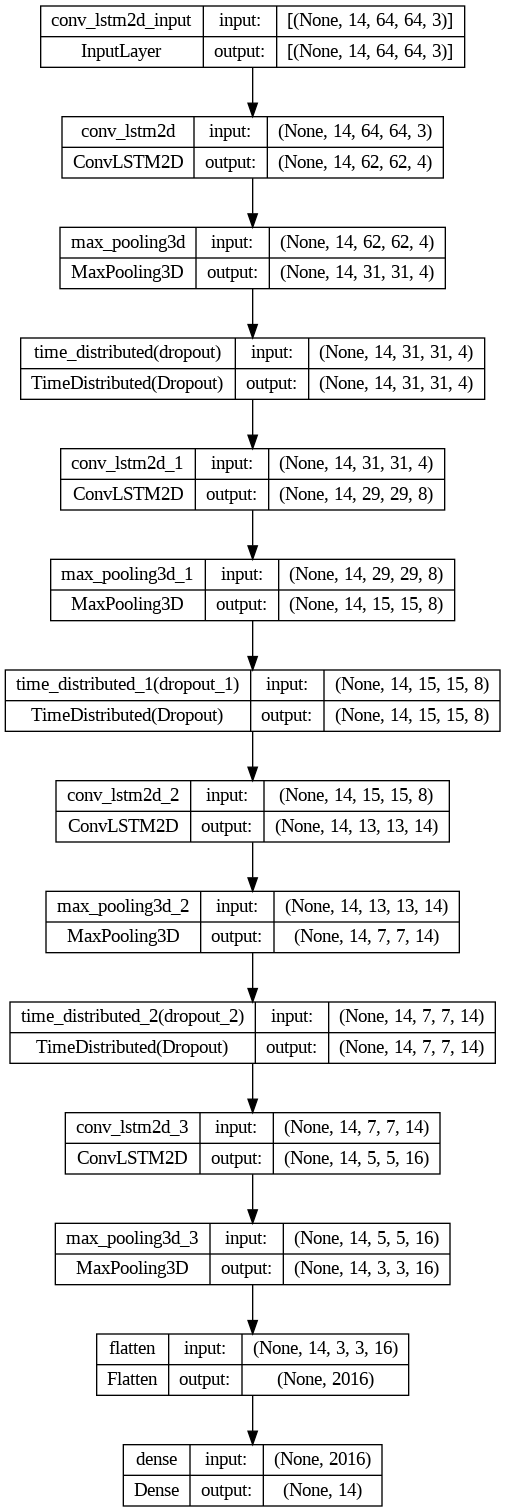

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
279/279 [==============================] - 58s 129ms/step - loss: 2.6438 - accuracy: 0.0735 - val_loss: 2.6431 - val_accuracy: 0.0643
Epoch 2/50
279/279 [==============================] - 34s 122ms/step - loss: 2.5468 - accuracy: 0.1308 - val_loss: 2.2666 - val_accuracy: 0.2000
Epoch 3/50
279/279 [==============================] - 34s 123ms/step - loss: 2.1770 - accuracy: 0.2428 - val_loss: 1.7959 - val_accuracy: 0.4143
Epoch 4/50
279/279 [==============================] - 34s 121ms/step - loss: 1.7545 - accuracy: 0.3934 - val_loss: 1.5246 - val_accuracy: 0.5071
Epoch 5/50
279/279 [==============================] - 34s 121ms/step - loss: 1.3360 - accuracy: 0.5367 - val_loss: 1.2240 - val_accuracy: 0.5429
Epoch 6/50
279/279 [==============================] - 34s 121ms/step - loss: 1.0899 - accuracy: 0.6039 - val_loss: 1.2694 - val_accuracy: 0.5857
Epoch 7/50
279/279 [==============================] - 34s 121ms/step - loss: 0.8745 - accuracy: 0.6935 - val_loss: 1.1530 - val_ac

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

15/15 [==============================] - 2s 54ms/step - loss: 0.6585 - accuracy: 0.8197


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = path+f'models/convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

  saving_api.save_model(



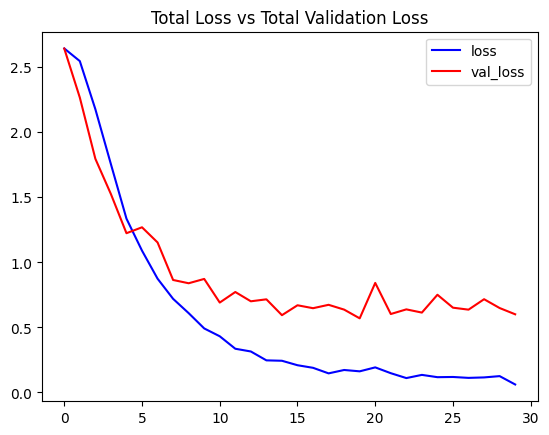

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

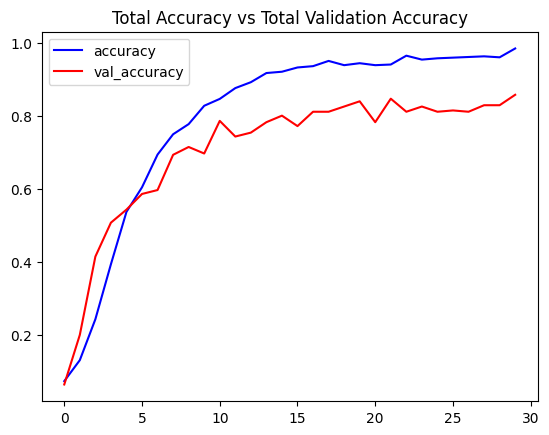

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history,  'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    # model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 14, 64, 64, 16)    448       
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 14, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 14, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 14, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 14, 4, 4, 32)     

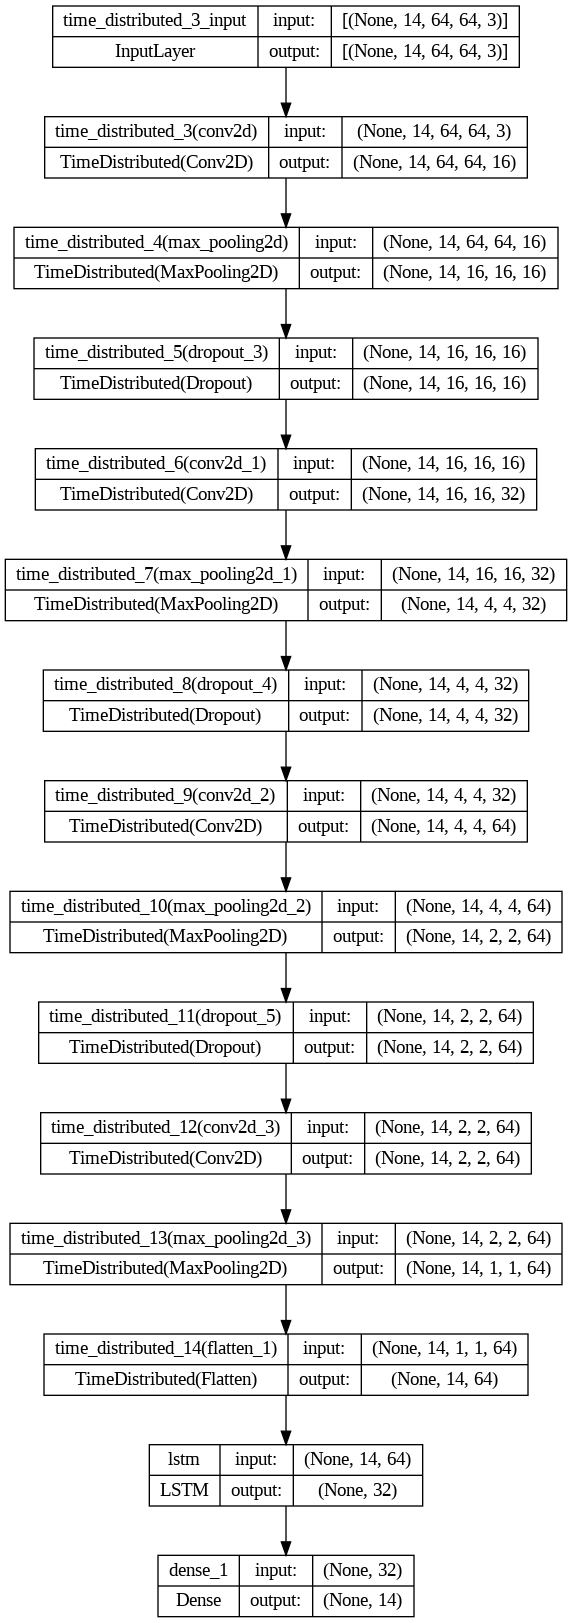

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 30, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# # Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 500, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])
# LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 500, batch_size = 4 ,
#                                              shuffle = True, validation_split = 0.2)

Epoch 1/500
279/279 [==============================] - 8s 11ms/step - loss: 2.6443 - accuracy: 0.0609 - val_loss: 2.6426 - val_accuracy: 0.0571
Epoch 2/500
279/279 [==============================] - 2s 8ms/step - loss: 2.6404 - accuracy: 0.0789 - val_loss: 2.6416 - val_accuracy: 0.0500
Epoch 3/500
279/279 [==============================] - 2s 8ms/step - loss: 2.4839 - accuracy: 0.1452 - val_loss: 2.2779 - val_accuracy: 0.1857
Epoch 4/500
279/279 [==============================] - 2s 8ms/step - loss: 2.2244 - accuracy: 0.2213 - val_loss: 2.0825 - val_accuracy: 0.2679
Epoch 5/500
279/279 [==============================] - 2s 8ms/step - loss: 2.0810 - accuracy: 0.2778 - val_loss: 1.9397 - val_accuracy: 0.3143
Epoch 6/500
279/279 [==============================] - 2s 8ms/step - loss: 1.9259 - accuracy: 0.3477 - val_loss: 1.8066 - val_accuracy: 0.4071
Epoch 7/500
279/279 [==============================] - 2s 8ms/step - loss: 1.8431 - accuracy: 0.3799 - val_loss: 1.7535 - val_accuracy: 0.392

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

15/15 [==============================] - 1s 22ms/step - loss: 0.4524 - accuracy: 0.8755


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = path+f'models/LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

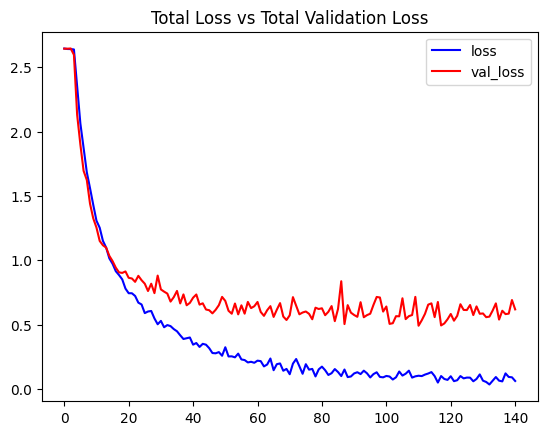

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

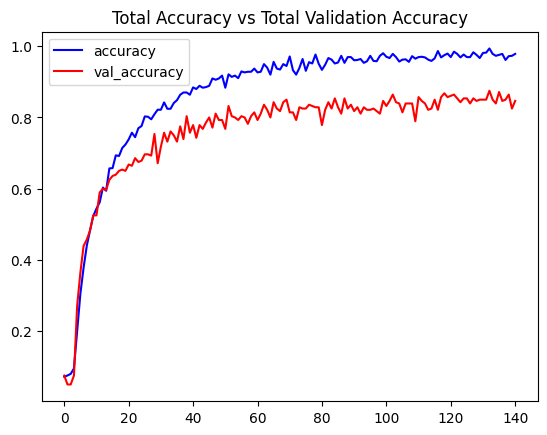

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''

     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)

     # Retrieve the title of the video.
     title = video.title

     # Get the best available quality object for the video.
     video_best = video.getbest()

     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'

     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)

     # Return the video title.
     return title

In [ ]:
# # Make the Output directory if it does not exist
# test_videos_directory = path+'test_videos'
# os.makedirs(test_videos_directory, exist_ok = True)

# # https://www.youtube.com/shorts/YauT5rAcHZQ
# # Download a YouTube Video.
# video_title = download_youtube_videos('https://www.youtube.com/watch?v=LK04r4imMgI', test_videos_directory)

# # Get the YouTube Video's path we just downloaded.
# input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [ ]:
# input_video_file_path = path+'test_videos/1_2.MP4'
input_video_file_path = path+'test_videos/2.mp4'
# input_true_labels = path+"video_labels/dancer2/1.csv"
from keras.models import load_model
LRCN_model = load_model(path+'models/LRCN_model___Date_Time_2023_09_05__21_55_48___Loss_0.5595896244049072___Accuracy_0.8369098901748657.h5')

In [ ]:
  def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH, LRCN_model, input_true_labels = None):
      '''
      This function will perform action recognition on a video using the LRCN model.
      Args:
      video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
      output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
      SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
      '''
      # labels_df = pd.read_csv(input_true_labels, header = None, index_col=0)
      # labels_df.columns = ['labels']
      # labels_df.reset_index(drop = True, inplace = True)
      # Initialize the VideoCapture object to read from the video file.
      video_reader = cv2.VideoCapture(video_file_path)

      # Get the width and height of the video.
      original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
      original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

      # Initialize the VideoWriter Object to store the output video in the disk.
      video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

      # Declare a queue to store video frames.
      frames_queue = deque(maxlen = SEQUENCE_LENGTH)

      # Initialize a variable to store the predicted action being performed in the video.
      predicted_class_name = ''

      idx = 0

      # Iterate until the video is accessed successfully.
      while video_reader.isOpened():

          # Read the frame.
          ok, frame = video_reader.read()

          # Check if frame is not read properly then break the loop.
          if not ok:
              break

          # Resize the Frame to fixed Dimensions.
          resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

          # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
          normalized_frame = resized_frame / 255

          # Appending the pre-processed frame into the frames list.
          frames_queue.append(normalized_frame)

          # Check if the number of frames in the queue are equal to the fixed sequence length.
          if len(frames_queue) == SEQUENCE_LENGTH:

              # Pass the normalized frames to the model and get the predicted probabilities.
              predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
              # print(predicted_labels_probabilities)
              # Get the index of class with highest probability.
              predicted_label = np.argmax(predicted_labels_probabilities)
              # Get the class name using the retrieved index.
              predicted_class_name = le.inverse_transform([predicted_label])[0] #+ '/' + labels_df['labels'][idx]
          # Write predicted class name on top of the frame.
          cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

          # plt.imshow(frame);plt.axis('off')
          # Write The frame into the disk using the VideoWriter Object.
          video_writer.write(frame)
          # print(predicted_class_name)
          # # print(predicted_labels_probabilities)
          # plt.imshow(frame);plt.axis('off')
          # plt.show()
          # idx += 1

      # Release the VideoCapture and VideoWriter objects.
      video_reader.release()
      video_writer.release()

In [ ]:
# Construct the output video path.
output_video_file_path = path+f'test_videos/1_{SEQUENCE_LENGTH}.mp4'
# Perform Action Recognition on the Test Video.
%time predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH, LRCN_model)

1/1 [==============================] - 0s 19ms/step
CPU times: user 1min 28s, sys: 4.46 s, total: 1min 32s
Wall time: 1min 27s


In [ ]:
for i in range(14):
  print(i,':',le.inverse_transform([i])[0])

0 : Aida
1 : Alemana
2 : Fan
3 : FootChange
4 : HandToHandL
5 : HandToHandR
6 : HockyStick
7 : NaturalTop
8 : NewYorkL
9 : NewYorkR
10 : NotPerforming
11 : OpenBasic
12 : OpeningOut
13 : SpotTurn


In [ ]:
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None))


In [ ]:
# Initialize a VideoCapture object to read from the video File.
video_reader = cv2.VideoCapture(path+'videos/dancer2/3.MP4')
labels_df = pd.read_csv(path+"video_labels/dancer2/video_3.csv", header = None, index_col=0)
labels_df.columns = ['labels']
labels_df.reset_index(drop = True, inplace = True)
# labels.columns = ['index', 'label']
# Read the first frame of the video file.
_, bgr_frame = video_reader.read()

# Release the VideoCapture object.
video_reader.release()

# Convert the frame from BGR into RGB format.
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
selected_class_Name = labels_df.iloc[1].values[0]
# Write the class name on the video frame.
cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# Display the frame.
# plt.subplot(5, 4, 1);
plt.imshow(rgb_frame);plt.axis('off')